In [5]:
import pandas as pd
# Cargamos los datos
import pandas as pd

data = pd.read_csv("Sleep_dataset.csv", sep=";")

In [6]:
data = pd.read_csv("Sleep_dataset.csv")
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [8]:
data.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [9]:
print(data.isnull().sum())

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# HISTOGRAMAS

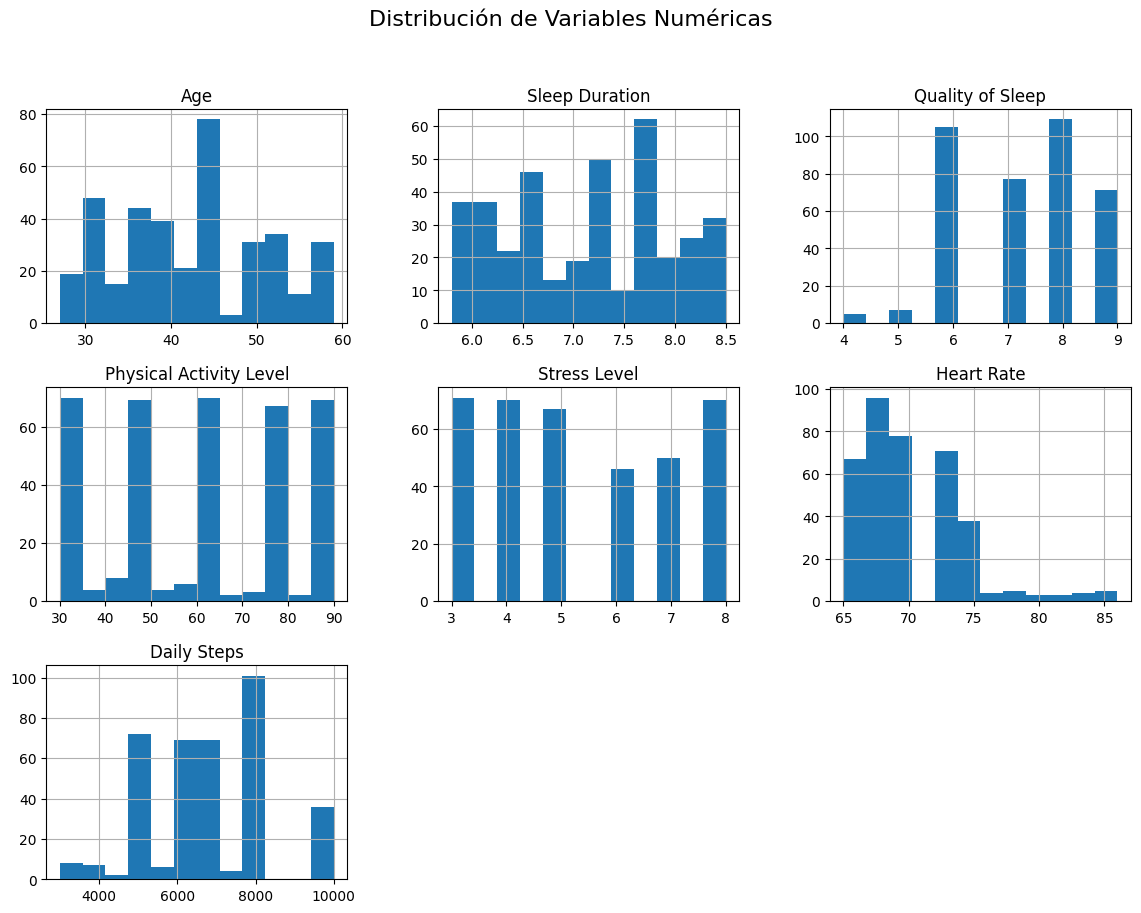

In [12]:
numeric_cols = [
    "Age", "Sleep Duration", "Quality of Sleep",
    "Physical Activity Level", "Stress Level",
    "Heart Rate", "Daily Steps"
]

data[numeric_cols].hist(figsize=(14,10), bins=12)
plt.suptitle("Distribución de Variables Numéricas", fontsize=16)
plt.show()


# BOXPLOTS PARA OUTLIERS

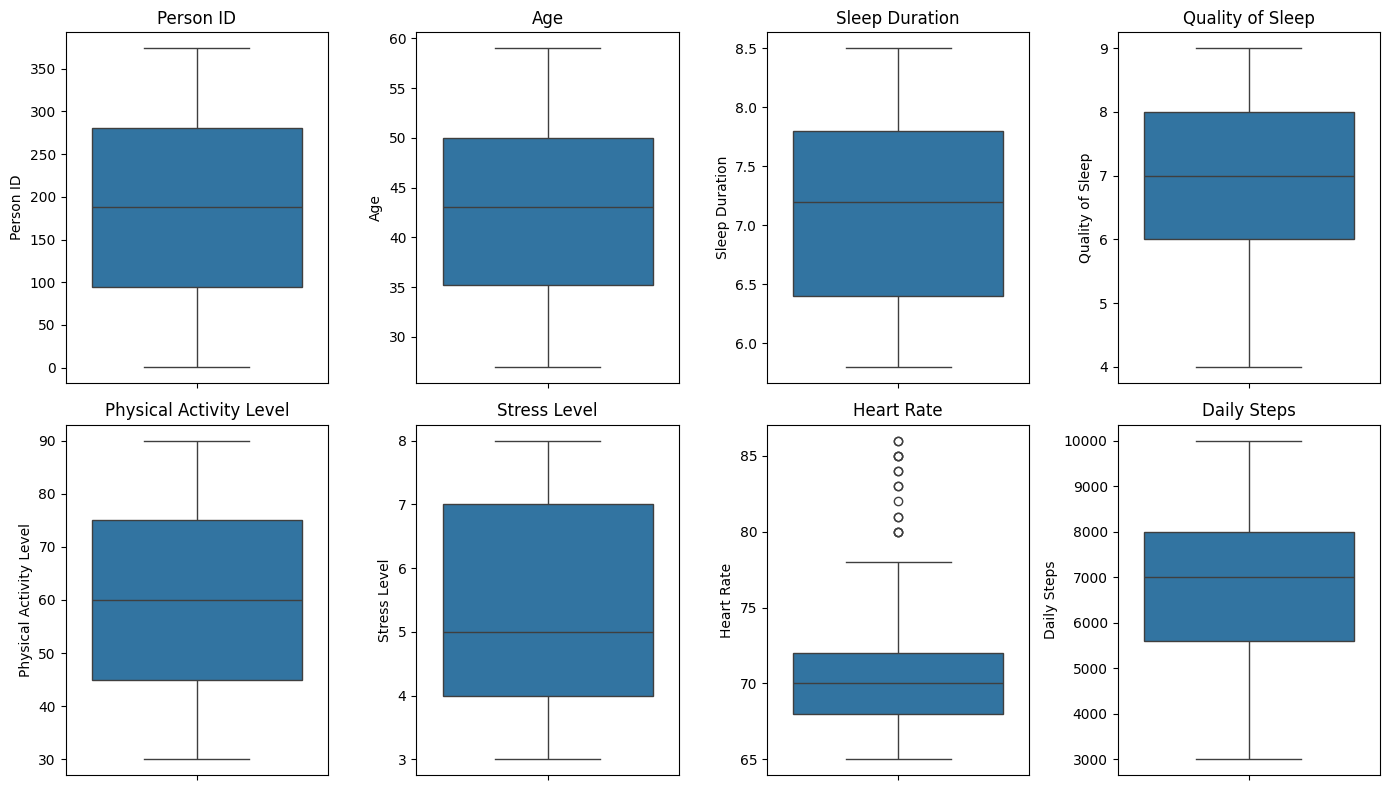

In [13]:
numeric_cols = data.select_dtypes(include="number").columns.tolist()

plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# MAPA DE CALOR DE CORRELACIONES

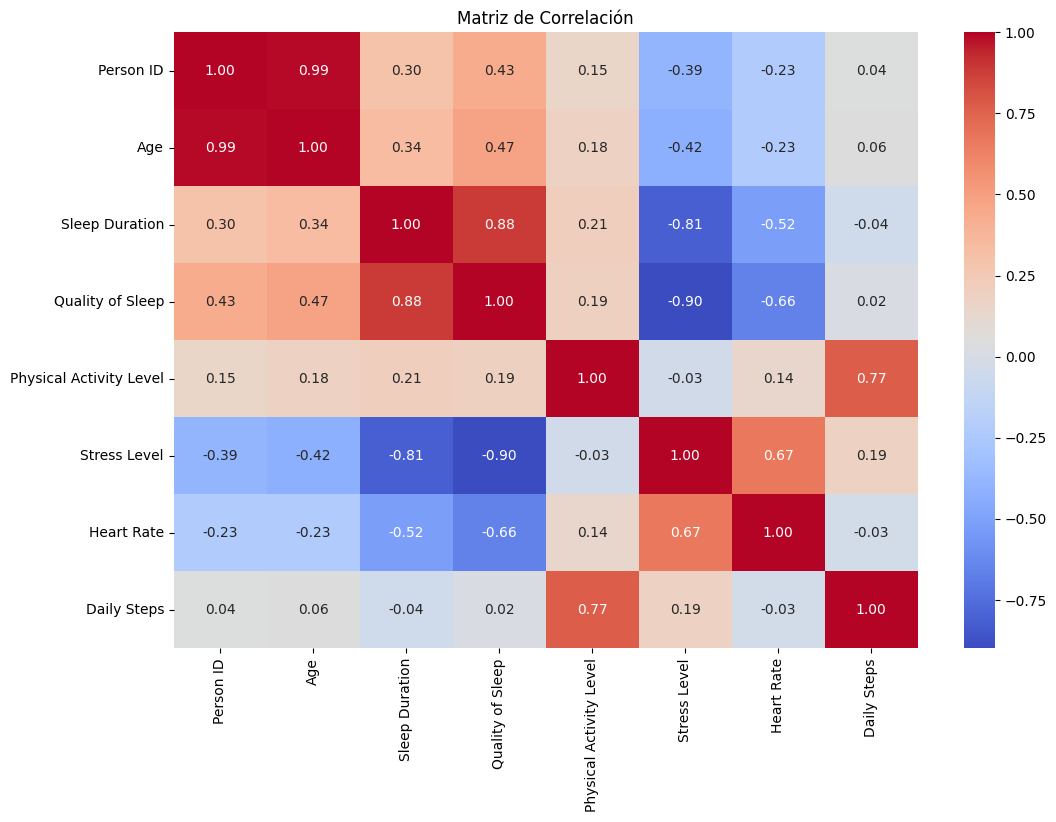

In [15]:
plt.figure(figsize=(12, 8))
corr = data[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# GRAFICO DE VARIABLES CATEGÓRICAS

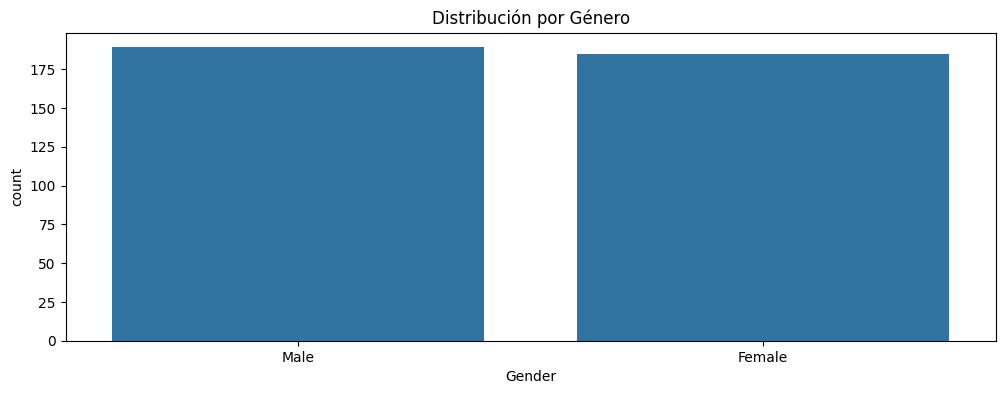

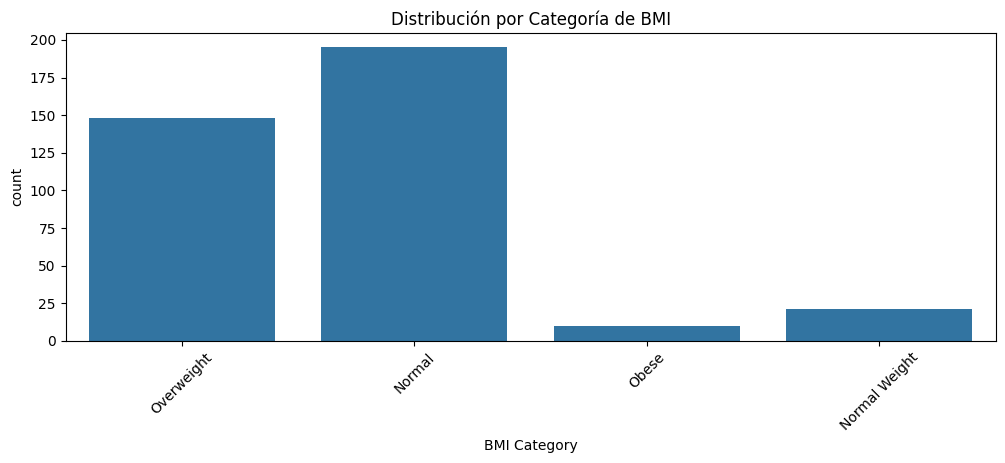

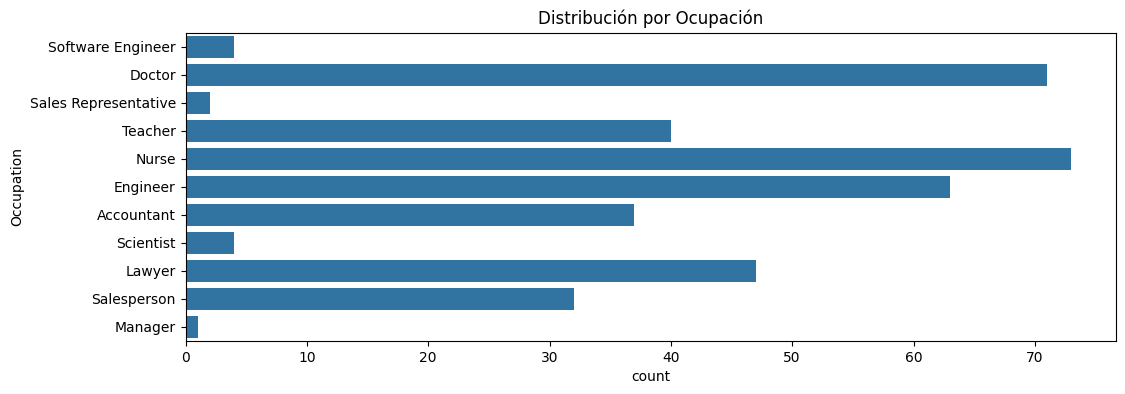

In [16]:

plt.figure(figsize=(12,4))
sns.countplot(x=data["Gender"])
plt.title("Distribución por Género")
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(x=data["BMI Category"])
plt.title("Distribución por Categoría de BMI")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(y=data["Occupation"])
plt.title("Distribución por Ocupación")
plt.show()


# 1. Random Forest: Modelo Base Robusto y Explicable

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Instanciar modelo base
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_model


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 2. XGBoost: Modelo de Alto Rendimiento

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# 3. Regresión Logística: Modelo Base Lineal

In [21]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    class_weight="balanced"
)

logreg_model


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


# 4. K-Means: Ingeniería de Características con Aprendizaje No Supervisado

In [22]:
from sklearn.cluster import KMeans

cluster_features = data[["Physical Activity Level", "Daily Steps", "Heart Rate"]]

kmeans = KMeans(n_clusters=3, random_state=42)
data["Lifestyle Cluster"] = kmeans.fit_predict(cluster_features)

data["Lifestyle Cluster"].value_counts()


Lifestyle Cluster
0    210
1    147
2     17
Name: count, dtype: int64

# VI - Construcción y entrenamiento de modelos

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Cargar dataset
data = pd.read_csv("Sleep_dataset.csv")

# Eliminar filas sin etiqueta
data = data.dropna(subset=["Sleep Disorder"])

# Definir variables
X = data.drop(columns=["Sleep Disorder", "Person ID"])
y = data["Sleep Disorder"]

# Columnas
numeric_cols = ["Age", "Sleep Duration", "Quality of Sleep",
                "Physical Activity Level", "Stress Level",
                "Heart Rate", "Daily Steps"]

categorical_cols = ["Gender", "Occupation", "BMI Category", "Blood Pressure"]

# Preprocesamiento
preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

print(preprocess)


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'Sleep Duration', 'Quality of Sleep',
                                  'Physical Activity Level', 'Stress Level',
                                  'Heart Rate', 'Daily Steps']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Occupation', 'BMI Category',
                                  'Blood Pressure'])])


In [25]:
# División de datos
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Tamaños -> Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Tamaños -> Train: (108, 11) | Val: (23, 11) | Test: (24, 11)


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
print(class_weights_dict)


{'Insomnia': np.float64(1.0), 'Sleep Apnea': np.float64(1.0)}


In [28]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("Distribución ROS:", y_train_ros.value_counts())


Distribución ROS: Sleep Disorder
Sleep Apnea    54
Insomnia       54
Name: count, dtype: int64


In [29]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
print(smote)


SMOTE(random_state=42)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logreg_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=300, class_weight="balanced"))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))


=== Logistic Regression ===
              precision    recall  f1-score   support

    Insomnia       0.85      0.92      0.88        12
 Sleep Apnea       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24

[[11  1]
 [ 2 10]]


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=250,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

    Insomnia       0.85      0.92      0.88        12
 Sleep Apnea       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24

[[11  1]
 [ 2 10]]


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
numeric_cols = ["Age", "Sleep Duration", "Quality of Sleep",
                "Physical Activity Level", "Stress Level",
                "Heart Rate", "Daily Steps"]
categorical_cols = ["Gender", "Occupation", "BMI Category", "Blood Pressure"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

xgb_model = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    eval_metric="logloss"
)

xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb_model)
])
from sklearn.preprocessing import LabelEncoder

# Convertir la variable objetivo a números
le = LabelEncoder()
data["Sleep Disorder"] = le.fit_transform(data["Sleep Disorder"])

print("Clases codificadas:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Definir X, y nuevamente
X = data.drop(columns=["Sleep Disorder", "Person ID"])
y = data["Sleep Disorder"]

# Volver a dividir el dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Entrenar XGBoost
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


Clases codificadas:
{'Insomnia': np.int64(0), 'Sleep Apnea': np.int64(1)}
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.83      0.83      0.83        12

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24

[[10  2]
 [ 2 10]]


In [54]:
import numpy as np  

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
num_clases = len(np.unique(y_train))

# Ajusta el ColumnTransformer/OneHotEncoder/etc.
preprocess.fit(X_train)

X_train_processed = preprocess.transform(X_train).toarray()
X_val_processed   = preprocess.transform(X_val).toarray()
X_test_processed  = preprocess.transform(X_test).toarray()

model = Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_clases, activation='softmax')
])

from tensorflow.keras.utils import to_categorical
y_train_ohe = to_categorical(y_train, num_classes=num_clases)
y_val_ohe   = to_categorical(y_val,   num_classes=num_clases)
y_test_ohe  = to_categorical(y_test,  num_classes=num_clases)


In [55]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

num_clases = len(np.unique(y_train))

model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_processed.shape[1],)),
    Dense(32, activation="relu"),
    Dense(num_clases, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_processed, y_train_ohe,
    validation_data=(X_val_processed, y_val_ohe),
    epochs=50,
    batch_size=32
)

Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8796 - loss: 0.5407 - val_accuracy: 0.7826 - val_loss: 0.5641
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9074 - loss: 0.4641 - val_accuracy: 0.7391 - val_loss: 0.5201
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8981 - loss: 0.4074 - val_accuracy: 0.7826 - val_loss: 0.4857
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8889 - loss: 0.3592 - val_accuracy: 0.7826 - val_loss: 0.4605
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8981 - loss: 0.3171 - val_accuracy: 0.7826 - val_loss: 0.4395
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9074 - loss: 0.2810 - val_accuracy: 0.7826 - val_loss: 0.4265
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8981 - loss: 0.2521 - val_accuracy: 0.7826 - val_loss: 0.4223
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9074 - loss: 0.2278 - val_accuracy: 0.7826 - val_loss: 0.4148
Epoch 9/50


In [ ]:
# Predicciones MLP 
y_pred_prob = model.predict(X_test_processed)
y_pred = y_pred_prob.argmax(axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


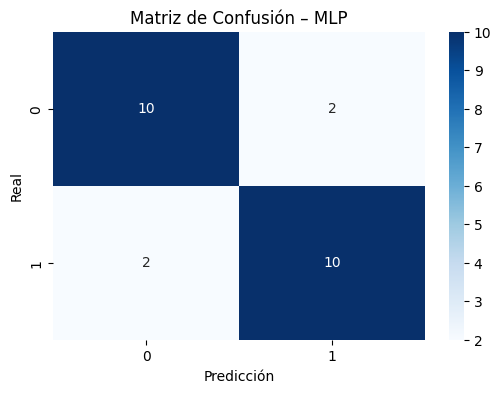

In [71]:
#Matriz de Confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_enc = np.argmax(y_test_ohe, axis=1)
y_pred     = np.argmax(model.predict(X_test_processed), axis=1)

cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión – MLP")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [72]:
#reporte de clasificacion
from sklearn.metrics import classification_report
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    Insomnia       0.83      0.83      0.83        12
 Sleep Apnea       0.83      0.83      0.83        12

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



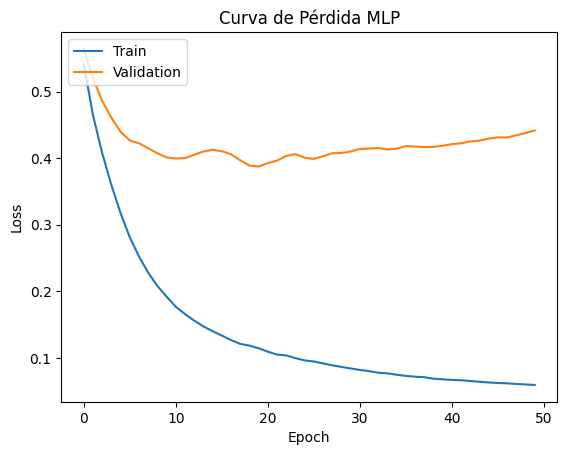

In [73]:
# Curva de perdida

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Curva de Pérdida MLP")
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


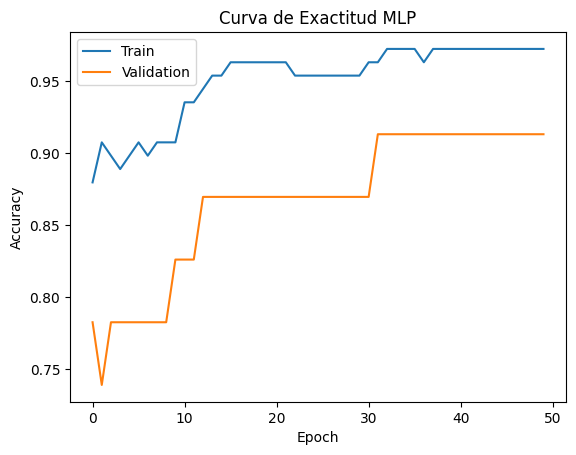

In [ ]:
# curva de accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Exactitud MLP')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')  
plt.show()

